<a href="https://colab.research.google.com/github/threegenie/knn_project/blob/main/new_work_times_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os, sys
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
# df1 = pd.read_csv('/content/drive/My Drive/df_2016.csv',encoding= 'unicode_escape')
# df2 = pd.read_csv('/content/drive/My Drive/df_2017.csv',encoding= 'unicode_escape')
# df3 = pd.read_csv('/content/drive/My Drive/df_2018.csv',encoding= 'unicode_escape')
# df4 = pd.read_csv('/content/drive/My Drive/df_2019.csv',encoding= 'unicode_escape')
df = pd.read_csv('/content/drive/My Drive/df_2020.csv',encoding= 'unicode_escape')

#원래는 2016~2020 New York Times 기사를 전부 쓰고 싶었으나..... 시간적 한계로 2020년 데이터만 사용 ㅠㅠ 

Mounted at /content/drive


In [2]:
df.head()

,Unnamed: 0,year,sentence
0,0,2020,The fugitive from Japan has put Lebanon in an ...
1,1,2020,Mixed reaction to the news that Maj. Gen. Qass...
2,2,2020,"In bronze, silver or aluminum, a statue is an ..."
3,3,2020,"Also this week, holiday fireworks in Iceland a..."
4,4,2020,"The teenager, accused in the death of the Barn..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69119 entries, 0 to 69118
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  69119 non-null  int64 
 1   year        69119 non-null  int64 
 2   sentence    69119 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.6+ MB


In [4]:
# 분석에 필요없는 열 제거
df = df.drop(['Unnamed: 0','year'],axis=1)

In [5]:
# 중복 기사 제거
df = df.drop_duplicates('sentence',keep='first')

In [6]:
# 제거 결과 확인
df.head()

,sentence
0,The fugitive from Japan has put Lebanon in an ...
1,Mixed reaction to the news that Maj. Gen. Qass...
2,"In bronze, silver or aluminum, a statue is an ..."
3,"Also this week, holiday fireworks in Iceland a..."
4,"The teenager, accused in the death of the Barn..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42420 entries, 0 to 69113
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  42420 non-null  object
dtypes: object(1)
memory usage: 662.8+ KB


#### 토큰 정제

In [8]:
!pip install squarify

In [9]:
import re
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokenizer import Tokenizer

In [10]:
#기본 불용어 불러오기
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)
print(nlp.Defaults.stop_words)

{'yourself', 'five', 'down', '‘s', 'always', 'someone', 'whole', 'unless', 'upon', 'used', 'almost', 'much', 'least', 'yet', 'us', 'else', 'for', 'part', 'afterwards', 'them', 'make', 'can', 'per', 'now', 'four', 'became', 'below', 'whose', 'must', 'is', 'be', 'same', 'being', 'amount', 'front', 'after', 'only', 'various', 'how', 'did', 're', 'nowhere', 'hence', 'could', 'any', 'throughout', 'by', '’ll', 'again', 'through', 'why', 'sixty', 'indeed', 'too', 'his', 'within', 'or', 'and', 'myself', "'m", 'this', 'hereafter', 'because', 'regarding', 'over', 'anyway', 'thence', 'never', 'she', 'call', 'there', '‘ll', "'ll", 'all', 'as', 'eight', 'although', 'full', "'d", 'elsewhere', '’m', 'itself', 'two', 'without', '’s', 'who', 'at', 'meanwhile', 'others', 'before', 'more', 'via', 'ten', 'take', 'ourselves', 'back', 'toward', 'to', 'nine', 'whether', 'whereas', 'together', 'bottom', 'therefore', 'third', 'go', 'amongst', 'empty', 'another', 'eleven', 'until', 'whence', 'still', 'except', 

In [11]:
#불용어 추가하기
st_words = nlp.Defaults.stop_words.union(['this', 'i', 'it', 'is', 'in', 'and', 'a', 'the', 'but', 'to', 'the',
                                          'said','york','u.s.','not','day','date','year','time'])

In [12]:
def tokenize(text):
  text = text.lower()
  text = text.replace("\n"," ")

  subst = ""
  regex = "[^a-zA-Z0-9 ]"
  doc = re.sub(regex, subst, text)

  doc = nlp(doc)
  tokens = []

  for token in doc :
    if (token.text.lower() not in st_words) & (token.is_stop == False) & (token.is_punct == False) & (token.is_alpha):
      tokens.append(token.lemma_)
      
  return tokens

In [13]:
df['Tokens']=df['sentence'].apply(tokenize)
df['Tokens'].head(3)

0    [fugitive, japan, lebanon, awkward, position, ...
1    [mixed, reaction, news, maj, gen, qassim, sule...
2    [bronze, silver, aluminum, statue, idea, solid...
Name: Tokens, dtype: object

#### 단어 빈도에 따라 시각화

In [14]:
def word_count(docs):
   
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [15]:
from collections import Counter
word_counts = Counter()
df['Tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('new', 7017),
 ('coronavirus', 6146),
 ('trump', 5318),
 ('president', 4088),
 ('pandemic', 3023),
 ('not', 3016),
 ('state', 2111),
 ('people', 2090),
 ('know', 2031),
 ('need', 2008)]

In [16]:
wc = word_count(df['Tokens'])
wc.head(5)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
35,new,6208,7017,1.0,0.009849,0.009849,0.146346
5481,coronavirus,5754,6146,2.0,0.008626,0.018475,0.135644
496,trump,4288,5318,3.0,0.007464,0.025939,0.101084
818,president,3711,4088,4.0,0.005738,0.031677,0.087482
10599,pandemic,2937,3023,5.0,0.004243,0.035920,0.069236


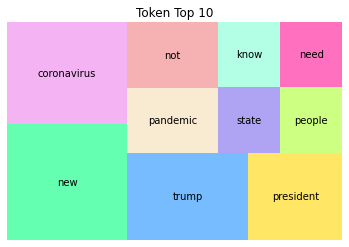

In [17]:
import squarify
import matplotlib.pyplot as plt

colors=['springgreen','violet','dodgerblue','gold','wheat','lightcoral',
        'mediumslateblue','greenyellow','aquamarine','deeppink']

wc_top5 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top5['percent'], label=wc_top5['word'], alpha=0.6, color=colors)
plt.axis('off')
plt.title('Token Top 10')
plt.show()

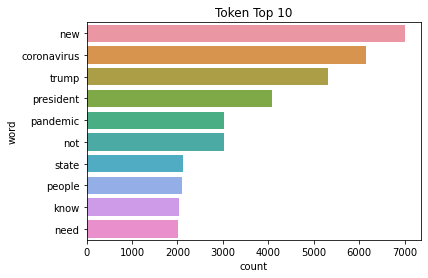

In [18]:
sns.set_palette('GnBu')
sns.barplot(x=wc['count'][:10],y=wc['word'][:10],orient='h')
plt.title('Token Top 10')
plt.show()

#### KNN + TfidVectorizer 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=st_words
                        ,tokenizer=tokenize
                        ,ngram_range = (1,2)
                        ,max_features = 5000
                        )
dtm = tfidf.fit_transform(df['sentence'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'm', 'nt', 's', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
dtm.head()

,aaron,abandon,abc,ability,able,aboard,abortion,abroad,abruptly,absence,absentee,absentee ballot,abuse,academic,academy,accelerate,accept,acceptance,access,accident,acclaim,accord,accord new,account,accountability,accurate,accusation,accuse,accuser,ace,achieve,achievement,acknowledge,acquire,acquit,acquittal,acre,act,action,active,...,world war,worldwide,worried,worry,worsen,worth,wound,wrap,wrestle,write,write book,writer,writing,writing prompt,wrong,wuhan,x,xi,yang,yankees,yard,yemen,yes,yield,yorker,yorkers,yorks,young,young adult,young child,young people,young woman,youth,youtube,zealand,zero,zone,zoo,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree') #최근접 5이웃
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [22]:
result = nn.kneighbors([dtm.iloc[10000]])
result

(array([[0.        , 1.        , 1.        , 1.        , 1.16302513]]),
 array([[10000,  5144, 10509, 35412, 15591]]))

In [23]:
df.iloc[result[1][0]]

,sentence,Tokens
16469,"Neighboring Iran, badly hit by the virus, cont...","[neighbor, iran, badly, hit, virus, continue, ..."
7717,What is this illustration saying? Maze,"[illustration, say, maze]"
17301,No. Should I Still Be Going Out?,[go]
58484,Dani Raymon bamboozles us. Puns and Anagrams,"[dani, raymon, bamboozle, pun, anagram]"
26540,"For this issue, a look at Afghanistan as the v...","[issue, look, afghanistan, virus, threaten, ex..."


In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(df['sentence'].iloc[result[1][0]])

16469    Neighboring Iran, badly hit by the virus, continues to allow thousands of people to cross into Afghanistan daily despite requests to close the border. In Afghanistan, Coronavirus Complicates War and Peace
7717     What is this illustration saying? Maze                                                                                                                                                                      
17301    No. Should I Still Be Going Out?                                                                                                                                                                            
58484    Dani Raymon bamboozles us. Puns and Anagrams                                                                                                                                                                
26540    For this issue, a look at Afghanistan as the virus threatens to explode with few resources to contain it. Behind the Cover: Afghanistan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


10000번째 기사를 읽었다면 16469, 77117, 17301, 58484, 26540 번째의 기사가 추천된다.
주로 전쟁에 관한 기사들이 추천되는 것을 볼 수 있다. 

#### 특정 주제에 관한 기사들을 분류하는 모델 만들기 - coronavirus에 대한 기사

**타겟 라벨 만들기**

In [25]:
for row in df['sentence']:
  df['sentence'] = df['sentence'].str.lower()

In [26]:
corona = df['sentence'].str.contains('coronavirus')
df['label'] = corona

In [27]:
df['label'] = df['label'].astype(int)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42420 entries, 0 to 69113
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  42420 non-null  object
 1   Tokens    42420 non-null  object
 2   label     42420 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [29]:
df['label'].value_counts()

0    36616
1    5804 
Name: label, dtype: int64

**훈련, 테스트셋 분리**

In [30]:
from sklearn.model_selection import train_test_split

train = df['sentence']
target = df['label']

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.3, random_state = 11)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((29694,), (12726,), (29694,), (12726,))

**Baseline**

In [38]:
#Baseline - logistic regression
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

vect = TfidfVectorizer(stop_words=st_words
                       , ngram_range=(1,2)
                       , min_df=2
                       , max_df=0.7
                        ,tokenizer=tokenize
                       , max_features=10000
                      )

svd = TruncatedSVD(algorithm='randomized'
                   , n_iter=5
                   , random_state=11)


lgs = LogisticRegression()

pipe_baseline = Pipeline([
  ('vect', vect)
  , ('svd', svd)
  , ('lgs', lgs)
])

In [39]:
pipe_baseline.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'm', 'nt', 's', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=10000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'acr...
                ('svd',
                 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
                              random_state=11, tol=0.0)),
                ('lgs',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
            

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred_base = pipe_baseline.predict(x_test)
accuracy_score(y_test, y_pred_base)

0.8615432971868615

In [41]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     10976
           1       0.48      0.10      0.16      1750

    accuracy                           0.86     12726
   macro avg       0.68      0.54      0.54     12726
weighted avg       0.82      0.86      0.82     12726



**Pipeline**

In [42]:
vect = TfidfVectorizer(stop_words=st_words
                       , ngram_range=(1,2)
                       , min_df=2
                       , max_df=0.7
                        ,tokenizer=tokenize
                       , max_features=10000
                      )

svd = TruncatedSVD(algorithm='randomized'
                   , n_iter=5
                   , random_state=11)

clf = RandomForestClassifier(n_estimators=500
                             , random_state=11)

pipe = Pipeline([
  ('vect', vect)
  , ('svd', svd)
  , ('clf', clf)
])

In [43]:
pipe.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'm', 'nt', 's', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=10000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", 'a', 'about', 'above',
                                             'acr...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_lea

**Cross Validation Parameter Search**

In [44]:
# 파라미터 셋팅
parameters = {
    'vect__max_df': (0.7, 1.0) 
    ,'vect__min_df': (2, 5, 10) 
    ,'vect__max_features': (5000, 20000) 
    ,'clf__n_estimators': (100, 500) 
    ,'clf__max_depth': (10, 20, None) 
}

random_search = RandomizedSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed: 23.7min remaining: 30.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 34.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'm', 'nt', 's', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.7,
                                                              max_features=10000,
                                                              min_df=2,
                                                       

In [45]:
random_search.best_score_

0.9264158724737765

In [46]:
random_search.best_params_

{'clf__max_depth': 10,
 'clf__n_estimators': 100,
 'vect__max_df': 0.7,
 'vect__max_features': 20000,
 'vect__min_df': 10}

**Accuracy score**

In [47]:
y_pred = random_search.predict(x_test)
accuracy_score(y_test, y_pred)

0.9252710985384253

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10976
           1       0.75      0.68      0.72      1750

    accuracy                           0.93     12726
   macro avg       0.85      0.82      0.84     12726
weighted avg       0.92      0.93      0.92     12726

